# Introduction to Pandas 2

Advanced Pandas syntax, aggregation, and joining.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

## 1. String Methods

Let's load the North Carolina `babynames` dataframe.

In [ ]:
import urllib.request
import os.path
import zipfile

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "babynamesbystate.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'NC.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header = None, names = field_names)

babynames.head()

**Question 1.1.** Find the most popular baby name in North Carolina in 2018.

In [ ]:
# Question 1.1.

**Question 1.2.** Find baby names that start with "J".

In [ ]:
# Question 1.2.
starts_with = [i.startswith("Gary") for i in babynames["Name"]]
year = [i == 1970 for i in babynames["Year"]]
name = "Rasheed"
birth_year = 1997
double_mask = (babynames["Name"] == name) & (babynames["Year"] == birth_year)
babynames[double_mask]

**Example 1.1.** Use the `Series.str` methods.

In [ ]:
babynames["Name"].str.startswith("J")

In [ ]:
s = babynames[babynames["Name"].str.startswith("J")]
s

**Question 1.3.** Find out how many babies were born in North Carolina with your name.

In [ ]:
# Question 1.3.

In [ ]:
babynames[babynames["Name"].str.contains("ad")].head()

In [ ]:
babynames["Name"].str.split("th").to_frame().head()

**Question 1.4.** Write a line of code that creates a list (or Series or array) of all names that end with “ert”..

In [ ]:
# Question 1.4.

## 2. Sort Names by Length

Suppose we want to sort all baby names in North Carolina by their length.

### 2.1. Create a Temporary Column

**Example 2.1.1.** Create a new series of only the lengths. Then add that series to the dataframe as a column. Then sort by that column. Then drop that column.

In [ ]:
# Create a new series of only the lengths
babyname_lengths = babynames["Name"].str.len()

# Add that series to the dataframe as a column
babynames["name_lengths"] = babyname_lengths
babynames.head(5)

In [ ]:
# Sort by the temporary column
babynames = babynames.sort_values(by = "name_lengths", ascending = False)
babynames.head()

In [ ]:
# Drop the temporary column
babynames = babynames.drop("name_lengths", axis = 'columns')
babynames.head()

In [ ]:
babynames["Count"].describe()

**Example 2.1.2.** We can also use the Python map function if we want to use an arbitrarily defined function. Suppose we want to sort by the number of occurrences of "dr" plus the number of occurences of "ea".

In [ ]:
def dr_ea_count(string):
    return string.count('dr') + string.count('ea')

# Create the temporary column
babynames["dr_ea_count"] = babynames["Name"].map(dr_ea_count)

# Sort by the temporary column
babynames = babynames.sort_values(by = "dr_ea_count", ascending = False)
babynames.head()

In [ ]:
# Drop that column
babynames = babynames.drop("dr_ea_count", 1)
babynames.head(5)

### 2.2. Generate a Sorted Index

**Example 2.2.1.** Let's start over by first scrambling the order of babynames.

In [ ]:
babynames = babynames.sample(frac = 1)
babynames.head(5)

**Example 2.2.2.** Another approach is to take advantage of the fact that .loc can accept an index. That is:

- df.loc[idx] returns df with its rows in the same order as the given index.
- Only works if the index exactly matches the DataFrame.

The first step was to create a sequence of the lengths of the names.

In [ ]:
name_lengths = babynames["Name"].str.len()
name_lengths.head(5)

**Example 2.2.3.** The next step is to sort the new series we just created.

In [ ]:
name_lengths_sorted_by_length = name_lengths.sort_values()
name_lengths_sorted_by_length.head(5)

**Example 2.2.4.** Next, we pass the index of the sorted series to the loc method of the original dataframe.

In [ ]:
index_sorted_by_length = name_lengths_sorted_by_length.index
index_sorted_by_length

In [ ]:
babynames.loc[index_sorted_by_length].head()

**Example 2.2.5.** Note we can do this all in one line.

In [ ]:
babynames.loc[babynames["Name"].str.len().sort_values().index].head(5)

## 3. Name Whose Popularity has Changed the Most

**Example 3.1.** First we need to define change in popularity. For the purposes of lecture, let’s stay simple and use the AMMD (absolute max/min difference):

$$\text{max(count)} - \text{min(count).}$$

To make sure we understand this quantity, let's consider the name Jennifer.

In [ ]:
def ammd(series):
    return max(series) - min(series)

name = 'Jennifer'
name_counts = babynames[babynames.Name == name]["Count"]

ammd(name_counts)

### 3.1. For Loop

**Example 3.1.1.** A basic for loop

**Note:** A Python dictionary is an implementation of a data structure that is more generally known as an associative array. A dictionary consists of a collection of key-value pairs. Each key-value pair maps the key to its associated value. For example:

`college_mascot = {'UNC' : 'Tarheel', 'Duke'   : 'Blue Devil', 'NC State': 'Wolf', 'NCCU': 'Eagle'}`

To access a value from a dictionary specify its corresponding key in square brackets ([]): 

`college_mascot['NCCU']`

'Eagle'

In [ ]:
# Build dictionary where entry i is the ammd function for the given name
# For example, ammd["Jennifer"] should be 1442
ammd_of_babyname_counts = {}

# Select unique names
for name in babynames["Name"].unique()[0:10]:                              # Only take 10 different names
    counts_of_current_name = babynames[babynames["Name"] == name]["Count"] # Find each row that contains the name and access the count
    ammd_of_babyname_counts[name] = ammd(counts_of_current_name)           # Use the ammd function to find difference between max and min count and store in dictionary with name
    
# Convert to series
ammd_of_babyname_counts = pd.Series(ammd_of_babyname_counts) 
ammd_of_babyname_counts

**Example 3.1.2.** The answer below only uses the first 100 names because otherwise the code takes ages to complete running.

In [ ]:
# Build dictionary where entry i is the ammd function for the given name
# For example, ammd["Jennifer"] should be 1442
ammd_of_babyname_counts = {}

# Select unique names
for name in babynames["Name"].unique()[0:100]:                             # Only take 10 different names
    counts_of_current_name = babynames[babynames["Name"] == name]["Count"] # Find each row that contains the name and access the count
    ammd_of_babyname_counts[name] = ammd(counts_of_current_name)           # Use the ammd function to find difference between max and min count and store in dictionary with name
    
# Convert to series
ammd_of_babyname_counts = pd.Series(ammd_of_babyname_counts) 
ammd_of_babyname_counts.head()

### 3.2. Use `groupby` and `agg`

**Example 3.2.1.** We can use the very powerful `groupby.agg` operation, which allows us to simply and efficiently compute what we want.

In [ ]:
babynames.groupby("Name").agg(max).head()

**Example 3.2.2.** Using the `ammd` functions for `agg()`.

In [ ]:
babynames.groupby("Name").agg(ammd).head()

**Note:** The result includes both a Year and Count column. The Count column is what we want, namely the AMMD for the name in that row. To check your understanding, try to figure out what the Year column represents.

To understand how `groupby` works, consider the visual diagram below. The `groupby` function clusters rows from the original dataframe into groups (which I call subframes). The `agg` function then condenses each subframe into a single representative row using the provided function $f$.

<center><img src="groupbyagg.png"></center>

**Example 3.2.3.** Let's actually build this DataFrame and play with it interactively to understand `groupby` better.

In [ ]:
d = pd.DataFrame(dict(x=[3,1,4,1,5,9,2,5,6], y=[12,7,3,2,7,3,8,6,7]), index=list('ABCABCACB') )
d

In [ ]:
dgb = d.groupby(d.index)
dgb

In [ ]:
dgb.groups

In [ ]:
dgb.groups['A']

In [ ]:
dgb.get_group('A')

In [ ]:
dgb.agg(ammd)

## 4. Some Additional Groupby Puzzles

### 4.1. Puzzle 1

Run the cell below.

In [ ]:
import urllib.request
import os.path
import zipfile
import pandas as pd

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "babynamesbystate.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'NC.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header = None, names = field_names)

def ammd(series):
    return max(series) - min(series)

babynames.head()

**Example 4.1.1** Test your understanding, by trying to interpret the result of the code below.

In [ ]:
babynames.groupby("Year").agg(ammd).plot();

**Example 4.1.2.** Let's look at the intermediate dataframes for each year.

In [ ]:
for i, (k, v) in enumerate(babynames.groupby("Year")):
    if i >= 3: break
    print(f"Year: {k}")
    display(v.head())

**Example 4.1.3.** For reference, the first 5 values from the plot above are:

In [ ]:
babynames.groupby("Year").agg(ammd).head()

### 4.2. Puzzle 2

In [ ]:
elections = pd.read_csv("elections.csv", index_col = [0])
elections.head()

**Example 4.2.1.** We have to be careful when using aggregation functions. For example, the code below might be misinterpreted to say that Woodrow Wilson ran for election in 2016. 

Why is this happening?

**Note:** Our dataframe will be different from the one in the video.

In [ ]:
elections.groupby("Party").agg(max).head()

### 4.3. Puzzle 3

**Example 4.3.1.** Inspired by above, try to predict the results of the groupby operation shown.

<center><img src="groupbyagg1.png"></center>


**Example 4.3.1.** What goes in the first box with **??**, the second box with **??**, and the third box with **??**?

In [ ]:
ds = pd.DataFrame(dict(x=[3,1,4,1,5,9,2,5,6], 
                      y=['ak', 'tx', 'fl', 'hi', 'mi', 'ak', 'ca', 'sd', 'nc']), 
                      index=list('ABCABCACB') )
ds

**Example 4.3.2.** Check your solutions by running the cell below.

In [ ]:
ds.groupby(ds.index).agg(max)

### 4.4. Puzzle 4

**Example 4.4.1.** Next we'll write code that properly returns the best result by each party. That is, each row should show the Year, Candidate, Popular Vote, Result, and % for the election in which that party saw its best results (rather than mixing them as in the example above), here's what the first rows of the correct output should look like:

<center><img src="groupbyagg2.png"></center>

In [ ]:
elections_sorted_by_percent = elections.sort_values("%", ascending = False)
elections_sorted_by_percent.groupby("Party").first()

**Example 4.4.2.** You'll soon discover that with Pandas' rich tool set, there's typically more than one way to get to the same answer. Each approach has different tradeoffs in terms of readability, performance, memory consumption, complexity and more. It will take some experience for you to develop a sense of which approach is better for each problem, but you should in general try to think if you can at least envision a different solution to a given problem, especially if you find your current solution to be particularly convoluted or hard to read.

Here's a couple of other ways of obtaining the same result (in each case we only show the top part with head()). The first approach uses groupby but finds the location of the maximum value via the `idxmax()` method (look up its documentation!). We then index and sort by party to match the requested formatting:

In [ ]:
elections.head()

In [ ]:
best_per_party = elections.loc[elections.groupby('Party')['%'].idxmax()]  # This is the computational part
best_per_party.set_index('Party').sort_index().head()                     # This indexes by Party to match the formatting above

In [ ]:
elections.groupby("Party")["%"].idxmax()

**Example 4.4.3.** And this one doesn't even use `groupby`. This approach instead uses the `drop_duplicates` method to keep only the last occurrence of of each party after having sorted by `"%"`, which is the best performance. Again, the second line is purely formatting.

In [ ]:
best_per_party2 = elections.sort_values('%').drop_duplicates(['Party'], keep = 'last')
best_per_party2.set_index('Party').sort_index().head()                                 # Formatting

## 5. Other `groupby` Features

**Example 5.1.** `groupby.size()`

In [ ]:
elections.groupby("Party")

In [ ]:
# Returns a Series giving the size of each group
elections.groupby("Party").size().head(10)

**Example 5.2.** `groupby.filter()`

In [ ]:
# Filter gives a copy of the original DataFrame where row r is included
# if its group obeys the given condition
#
# Note: Filtering is done per GROUP, not per ROW.
elections.groupby("Year").filter(lambda sf: sf["%"].max() < 52).sort_values("Year")

**Example 5.3.** Show steps of `groupby`.

In [ ]:
for i, (n, g) in enumerate(elections.groupby("Party")):
    print(n)
    display(g.head())
    if i>3: break

**Example 5.4.** `groupby.sum()`, `groupby.mean()`, etc.

In [ ]:
elections.groupby("Year").agg(sum).head()

In [ ]:
elections.groupby("Year").sum().head()

In [ ]:
elections.groupby("Year").agg(max).head()

In [ ]:
elections.groupby("Year").max().head()

In [ ]:
elections.groupby("Result").median().head()

In [ ]:
elections.groupby("Result").mean().head()

## 6. `groupby` and Pivot Tables

**Example 6.1.** Build a table showing the total number of babies born of each sex in each year.

In [ ]:
babynames.groupby(["Year", "Sex"]).sum()

In [ ]:
babynames.groupby(["Sex", "Year"]).sum()

In [ ]:
babynames.groupby(["Count", "Year", "Sex"]).sum().head()

**Example 6.2.** Finding the  number of babies born each year of each sex.

In [ ]:
babynames.groupby(["Sex", "Year"]).sum()

In [ ]:
babynames.head()

**Example 6.3.** Use a pivot table.

In [ ]:
babynames_pivot = babynames.pivot_table(
    index = "Year",   # Rows (turned into index)
    columns = "Sex",  # Column values
    values = "Count", # The fields to be processed in each group
    aggfunc = np.max, # Group operation
)
babynames_pivot.head()

The basic idea behind pivot tables is shown in the image below.

<center><img src="groupbyagg3.png"></center>

## 7. Join Review

In this section we'll briefly review joining tables as discussed in Data 8 (click [here](https://www.inferentialthinking.com/chapters/08/4/Joining_Tables_by_Columns.html) to review joining).

Often data is spread across two tables. Joining provides us with a way to naturally combine related tables.

Let's start by reading data from the given zip file. To showcase how to do read data that is inside zip files, we're going to use the `zipfile` module. Doing so will allow us to avoid needing to unzip the data. 


**Example 7.1.** Running the cell below, we see that the zip file contains `elections.csv` and `presidents.csv`.

In [3]:
import zipfile

join_demo_filename = "join_demo_data.zip"
my_zip = zipfile.ZipFile(join_demo_filename, 'r')
list_names = [f.filename for f in my_zip.filelist]
list_names

['elections.csv', 'presidents.csv']

**Example 7.2.** We could call `my_zip.extractall()` to unzip the files, but we won't. Instead, we'll read directly from the zip file itself.

In [4]:
with my_zip.open("elections.csv") as f:
    elections = pd.read_csv(f)
    
elections.head()

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878
2,1828,Andrew Jackson,Democratic,642806,win,56.203927
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073
4,1832,Andrew Jackson,Democratic,702735,win,54.574789


In [5]:
with my_zip.open("presidents.csv") as f:
    presidents = pd.read_csv(f)
    
presidents.head()

,Date of birth,President,Birthplace,State of birth,In office
0,"February 22, 1732",George Washington,Westmoreland County,Virginia,"(1st) April 30, 1789 – March 4, 1797"
1,"October 30, 1735",John Adams,Braintree,Massachusetts,"(2nd) March 4, 1797 – March 4, 1801"
2,"April 13, 1743",Thomas Jefferson,Shadwell,Virginia,"(3rd) March 4, 1801 – March 4, 1809"
3,"March 16, 1751",James Madison,Port Conway,Virginia,"(4th) March 4, 1809 – March 4, 1817"
4,"April 28, 1758",James Monroe,Monroe Hall,Virginia,"(5th) March 4, 1817 – March 4, 1825"


**Example 7.3.** To join tables `df` and `df2`, we call the function `df.merge(df2)`. Merge is just the word that the authors of pandas picked for joining tables. I don't know why.

**Note:** Unfortunately, Pandas also has a function called `df.join`. This is a limited version of merge. For the sake of generality, we will only use merge in this class.

We can use the merge function to combine these two tables: 

In [6]:
elections.merge(presidents, 
            how = "inner",
            left_on = "Candidate", right_on = "President")

,Year,Candidate,Party,Popular vote,Result,%,Date of birth,President,Birthplace,State of birth,In office
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
1,1828,Andrew Jackson,Democratic,642806,win,56.203927,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
2,1832,Andrew Jackson,Democratic,702735,win,54.574789,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
3,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,"July 11, 1767",John Quincy Adams,Braintree,Massachusetts,"(6th) March 4, 1825 – March 4, 1829"
4,1828,John Quincy Adams,National Republican,500897,loss,43.796073,"July 11, 1767",John Quincy Adams,Braintree,Massachusetts,"(6th) March 4, 1825 – March 4, 1829"
5,1836,Martin Van Buren,Democratic,763291,win,52.272472,"December 5, 1782",Martin Van Buren,Kinderhook,New York,"(8th) March 4, 1837 – March 4, 1841"
6,1840,Martin Van Buren,Democratic,1128854,loss,46.948787,"December 5, 1782",Martin Van Buren,Kinderhook,New York,"(8th) March 4, 1837 – March 4, 1841"
7,1848,Martin Van Buren,Free Soil,291501,loss,10.138474,"December 5, 1782",Martin Van Buren,Kinderhook,New York,"(8th) March 4, 1837 – March 4, 1841"
8,1836,William Henry Harrison,Whig,550816,loss,37.721543,"February 9, 1773",William Henry Harrison,Charles City County,Virginia,"(9th) March 4, 1841 – April 4, 1841"
9,1840,William Henry Harrison,Whig,1275583,win,53.051213,"February 9, 1773",William Henry Harrison,Charles City County,Virginia,"(9th) March 4, 1841 – April 4, 1841"


Notice that:

1. The output dataframe only contains rows that have names in both tables. For example, presidents before 1824 do not appear in the joined table because there was no popular vote before 1824.

2. The name Andrew Jackson occurred three times in the election table and shows up three times in the output.

3. Grover Cleveland occurs six times! Twice for every election he was in. This is because he appears three times in the elections table and twice in the presidents table. This results in 3 x 2 = 6 combinations.

4. Several presidents are missing because their names are not an exact match. For example, John F. Kennedy is "John Kennedy" in the elections table and "John F. Kennedy" in the presidents table.

**Example 7.4.** With the caveats above in mind, this merged DataFrame is handy because we can use it to plot, e.g. the age of each president when they were elected.

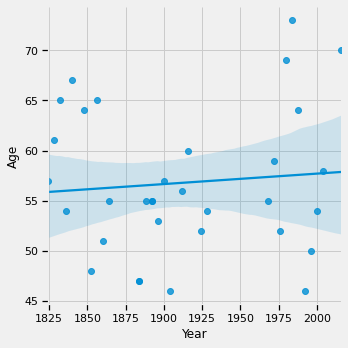

In [7]:
joined = elections.merge(presidents, 
            how = "inner",
            left_on = "Candidate", right_on = "President")

winners = joined.query("Result == 'win'").copy()
winners["Birthyear"] = winners["Date of birth"].str.split(',').str[1].map(int)
winners["Age"] = winners["Year"] - winners["Birthyear"]
sns.lmplot(data=winners, x="Year", y="Age");

### 7.1. How could we fix the duplicate Grover Cleveland?

**Example 7.1.2.** We could group by name/candidate and take only the first:

In [10]:
(
    elections.merge(presidents, 
            how = "inner",
            left_on = "Candidate", 
            right_on = "President").
    groupby(['Candidate', 'Year']).first().reset_index()
)

,Candidate,Year,Party,Popular vote,Result,%,Date of birth,President,Birthplace,State of birth,In office
0,Abraham Lincoln,1860,Republican,1855993,win,39.699408,"February 12, 1809",Abraham Lincoln,Sinking Spring,Kentucky,"(16th) March 4, 1861 – April 15, 1865"
1,Abraham Lincoln,1864,National Union,2211317,win,54.951512,"February 12, 1809",Abraham Lincoln,Sinking Spring,Kentucky,"(16th) March 4, 1861 – April 15, 1865"
2,Andrew Jackson,1824,Democratic-Republican,151271,loss,57.210122,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
3,Andrew Jackson,1828,Democratic,642806,win,56.203927,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
4,Andrew Jackson,1832,Democratic,702735,win,54.574789,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
5,Benjamin Harrison,1888,Republican,5443633,win,47.858041,"August 20, 1833",Benjamin Harrison,North Bend,Ohio,"(23rd) March 4, 1889 – March 4, 1893"
6,Benjamin Harrison,1892,Republican,5176108,loss,42.984101,"August 20, 1833",Benjamin Harrison,North Bend,Ohio,"(23rd) March 4, 1889 – March 4, 1893"
7,Bill Clinton,1992,Democratic,44909806,win,43.118485,"August 19, 1946",Bill Clinton,Hope,Arkansas,"(42nd) January 20, 1993 – January 20, 2001"
8,Bill Clinton,1996,Democratic,47400125,win,49.296938,"August 19, 1946",Bill Clinton,Hope,Arkansas,"(42nd) January 20, 1993 – January 20, 2001"
9,Calvin Coolidge,1924,Republican,15723789,win,54.329113,"July 4, 1872",Calvin Coolidge,Plymouth,Vermont,"(30th) August 2, 1923 – March 4, 1929"


### 7.2. Right Join

The above join was an inner join. 


**Example 7.2.1.** What if we wanted to keep all of the presidents and leave missing data for years when there was no popular vote? In this case we'd do a "right" join, where we make sure to include **every** row from our right dataframe, in this case presidents.

In [12]:
elections.merge(presidents, 
            how = "right",
            left_on = "Candidate", right_on = "President")

,Year,Candidate,Party,Popular vote,Result,%,Date of birth,President,Birthplace,State of birth,In office
0,NaN,NaN,NaN,NaN,NaN,NaN,"February 22, 1732",George Washington,Westmoreland County,Virginia,"(1st) April 30, 1789 – March 4, 1797"
1,NaN,NaN,NaN,NaN,NaN,NaN,"October 30, 1735",John Adams,Braintree,Massachusetts,"(2nd) March 4, 1797 – March 4, 1801"
2,NaN,NaN,NaN,NaN,NaN,NaN,"April 13, 1743",Thomas Jefferson,Shadwell,Virginia,"(3rd) March 4, 1801 – March 4, 1809"
3,NaN,NaN,NaN,NaN,NaN,NaN,"March 16, 1751",James Madison,Port Conway,Virginia,"(4th) March 4, 1809 – March 4, 1817"
4,NaN,NaN,NaN,NaN,NaN,NaN,"April 28, 1758",James Monroe,Monroe Hall,Virginia,"(5th) March 4, 1817 – March 4, 1825"
...,...,...,...,...,...,...,...,...,...,...,...
63,2000.0,George W. Bush,Republican,50456002.0,win,47.974666,"July 6, 1946",George W. Bush,New Haven,Connecticut,"(43rd) January 20, 2001 – January 20, 2009"
64,2004.0,George W. Bush,Republican,62040610.0,win,50.771824,"July 6, 1946",George W. Bush,New Haven,Connecticut,"(43rd) January 20, 2001 – January 20, 2009"
65,1992.0,Bill Clinton,Democratic,44909806.0,win,43.118485,"August 19, 1946",Bill Clinton,Hope,Arkansas,"(42nd) January 20, 1993 – January 20, 2001"
66,1996.0,Bill Clinton,Democratic,47400125.0,win,49.296938,"August 19, 1946",Bill Clinton,Hope,Arkansas,"(42nd) January 20, 1993 – January 20, 2001"


### 7.3. Left Join

**Example 7.3.1.** Similarly, if we also want to include candidates not in the presidents table (e.g. because they had never won), we can use a "left" join.

In [13]:
elections.merge(presidents, 
            how = "left",
            left_on = "Candidate", right_on = "President")

,Year,Candidate,Party,Popular vote,Result,%,Date of birth,President,Birthplace,State of birth,In office
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.210122,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.789878,"July 11, 1767",John Quincy Adams,Braintree,Massachusetts,"(6th) March 4, 1825 – March 4, 1829"
2,1828,Andrew Jackson,Democratic,642806,win,56.203927,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
3,1828,John Quincy Adams,National Republican,500897,loss,43.796073,"July 11, 1767",John Quincy Adams,Braintree,Massachusetts,"(6th) March 4, 1825 – March 4, 1829"
4,1832,Andrew Jackson,Democratic,702735,win,54.574789,"March 15, 1767",Andrew Jackson,Waxhaws Region,South/North Carolina,"(7th) March 4, 1829 – March 4, 1837"
...,...,...,...,...,...,...,...,...,...,...,...
176,2016,Donald Trump,Republican,62984828,win,46.407862,"June 14, 1946",Donald Trump,Queens,New York,"(45th) January 20, 2017 – Incumbent"
177,2016,Evan McMullin,Independent,732273,loss,0.539546,NaN,NaN,NaN,NaN,NaN
178,2016,Gary Johnson,Libertarian,4489235,loss,3.307714,NaN,NaN,NaN,NaN,NaN
179,2016,Hillary Clinton,Democratic,65853514,loss,48.521539,NaN,NaN,NaN,NaN,NaN


### 7.4. Outer Join

**Example 7.4.1.** If we wanted to keep both, we can instead do an "outer join".

In [ ]:
elections.merge(presidents, 
            how = "outer",
            left_on = "Candidate", right_on = "President")